In [1]:
from tensorflow import keras
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding
from tensorflow.keras.layers import SpatialDropout1D, Conv1D, GlobalMaxPooling1D # new! 
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt 
%matplotlib inline

### Setting hyperparameters

In [2]:
# output directory name:
output_dir = "model_output//"

# training:
epochs = 4
batch_size = 128

# vector space embedding:
n_dims = 64
n_unique_words = 5000   # taking just the top 5000 most commn words
max_review_length = 400    # maximum length a review can go upto
pad_type = trunc_type = 'pre'   # where to pad and truncate the sentence from
drop_embed = 0.2   # dropout after embedding layer

# convolution layer architecture
n_conv = 256
k_conv = 3 

# neural network architecture:
n_dense = 256
dropout = 0.2

### Load Data

In [3]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words) # removed n_words_to_skip

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\mukul\Anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
C:\Users\mukul\Anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is 

### Preprocessing the Data

In [4]:
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

## Designing the NN Architecture

In [5]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dims, input_length=max_review_length)) 
model.add(SpatialDropout1D(drop_embed))
model.add(Conv1D(n_conv, k_conv, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid'))

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 400, 64)           320000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 400, 64)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 398, 256)          49408     
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2

### Configuring the model

In [7]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"conv_sentiment_classifier_nlp.h5", save_best_only=True)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

### Training

In [9]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Epoch 1/4
196/196 [==============================] - 51s 261ms/step - loss: 0.4967 - accuracy: 0.7282 - val_loss: 0.3031 - val_accuracy: 0.8708
Epoch 2/4
196/196 [==============================] - 54s 278ms/step - loss: 0.2523 - accuracy: 0.8976 - val_loss: 0.2564 - val_accuracy: 0.8934
Epoch 3/4
196/196 [==============================] - 55s 281ms/step - loss: 0.1700 - accuracy: 0.9362 - val_loss: 0.2610 - val_accuracy: 0.8948
Epoch 4/4
196/196 [==============================] - 56s 288ms/step - loss: 0.1160 - accuracy: 0.9591 - val_loss: 0.2864 - val_accuracy: 0.8879


### Evaluation

In [10]:
model.load_weights(output_dir+"conv_sentiment_classifier_nlp.h5")

In [14]:
y_hat = model.predict(x_valid)

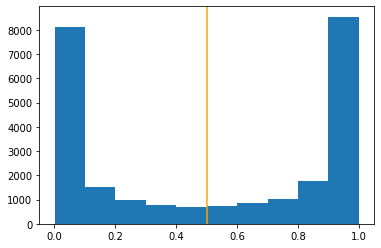

In [15]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')
plt.savefig('hist_plot.png')

In [16]:
"{:0.2f}".format(roc_auc_score(y_valid, y_hat)*100.0)

'96.01'